# Analytics and demand forecasting for a multi-national retail store 

##  Notebook by Edward Warothe


### Introduction

   In October 2017, the large Ecuadorian-based grocery retailer, Corporacion Favorita, posted its data [here](https://www.kaggle.com/c/favorita-grocery-sales-forecasting) on Kaggle for analytics and ML enthusiasts to predict the sales of various items for August 2017.
   
   The reason I chose this dataset was the fact that it was as close a real world dataset as one could get. It has a realistic relational data model and one can derive patterns from different perspectives depending on the angle of focus. I chose to focus on the demand planning aspect of the data; how can we get the right products to match the demand at a particular time. 
   
   There are 4 datasets in these analysis: stores -has location, type and cluster information about the 54 stores in check; items which has family, class and perishable columns; transactions -has daily average transactions for each store; oil -has the daily average oil price per barrel; and train, which has date, store number, item number, unit sales and on promotion columns. We'll analyze all these to look for patterns and\or interesting features in the data.
   
   At the moment of writing this article, I'm using a HP machine, core i7 with 8 GB RAM. Why is this information important? As you'll see the entire dataset takes around 5 GB in csv format which is too much for my machine to handle. My solution was to bucketize the train dataset into years (2013-2017). This method worked out especially well compared to several others I considered. I even have a short [medium article](https://eddywarothe.medium.com/is-your-data-too-big-for-your-ram-b3ed17a74095) comparing the different solutions I tried, results and compromises for each, and my choice, which is really important in case you come across a similar problem. 
   
   Using SQL via Postgresql was an option but since the data is small enough to load as an iterable, I chose pandas which is more versatile and powerful as compared to SQL. The reader will be keen to note, however, I have used SQL-like statements especially pandas' merge, value counts among other functions, given the relational nature of the data. 
   
****

#

In [1]:
# Fisrt, we load the required python packages to use in the analyses.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow
from fbprophet import Prophet
import plotly.offline as pyo
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import warnings
warnings.filterwarnings(action='once')

After loading the train dataset, I split it by year and persist it into my storage as a parquet file which preserves the data types I have preset and has approximately has read times 50% faster than csv. Before the split, I will separate the negative unit sale values from the positive ones. These negative values are from item returns. Later on, we'll analyze the returns data.

In [ ]:
dtype = {'store_nbr':np.int16, 'item_nbr':np.int32, 'unit_sales':np.float32, 'onpromotion':object}

chunks = pd.read_csv('C:/favorita2/train.csv', parse_dates=['date'], dtype=dtype,
                    chunksize=1000000, usecols=[1,2,3,4,5])

train = pd.DataFrame()    
for chunk in chunks:
    train = pd.concat([train, chunk])

returns = train[train['unit_sales']<0]
returns.to_csv('C:/returns.csv')

# then get the symmetric difference of the two
train = train.merge(returns,indicator = True, how='left').loc[lambda x: x['_merge']=='left_only']
   
# get the years by splitting    
year1 = train[train['date'].between('2013-01-01', '2013-12-31')]
year2 = train[train['date'].between('2014-01-01', '2014-12-31')]
year3 = train[train['date'].between('2015-01-01', '2015-12-31')]
year4 = train[train['date'].between('2016-01-01', '2016-12-31')]
year5 = train[train['date'].between('2017-01-01', '2017-12-31')]

# it's failrly easy to save each as a parquet file for later reference and analysis
year1.to_parquet('C:/year1.parquet', engine = 'pyarrow', index=False)

# to load the dataset
year1 = pd.read_parquet('C:/year1.parquet')

From this point, analysis becomes easier. Since our focus is on demand forecasting for certain items via time series analysis, we first answer some basic questions about our data : 
1. Which items are getting popular as time goes? (so as to stock more of these items depending on the time thy're popular)   2. Which are getting less popular? 
3. Which have consistently good sales? 
4. What family do the preceding items belong to? 
5. How does location affect sales? 
6. How does oil price and transaction number affect sales?
7. Which items were returned most? How did returns affect sales?
8. What are the expected forecast sales for September 2017?
We answer these and many more in our quest to extract as much info as possible from the dataset.

Since loading the entire dataset takes up a lot of time and resources, we'll load the chunks, which have been split by year, from now on.

In [37]:
items = pd.read_csv('C:/favorita2/items.csv')
year1 = pd.read_parquet('C:/favorita2/year1.parquet')
year2 = pd.read_parquet('C:/favorita2/year2.parquet')
year3 = pd.read_parquet('C:/favorita2/year3.parquet')
year4 = pd.read_parquet('C:/favorita2/year4.parquet')
year5 = pd.read_parquet('C:/favorita2/year5.parquet')

#### 1. which items had increasing demand over the years? (increasing number of sales counts)

In [39]:
def get_counts(data):
# function to get item count in a particular year
    item_count = data.item_nbr.value_counts().to_frame()
    item_count = item_count.reset_index(level=0)
    item_count.rename(columns={'index':'item_nbr', 'item_nbr':'counts'}, inplace=True)
    return item_count

count1 = get_counts(year1)
count2 = get_counts(year2)
count3 = get_counts(year3)
count4 = get_counts(year4)
count5 = get_counts(year5)

count1.head()

,item_nbr,counts
0,502331,16885
1,314384,16881
2,559870,16837
3,364606,16837
4,265559,16806


Next we write a function to get the item count percentage difference, e.g between year1(2013) and year2(2014), for items featured in both years.

In [7]:
# get difference in item count for 2 consecutive years
def get_diff(data1, data2):
    combined = data1.merge(data2, on = 'item_nbr', how = 'inner', suffixes = ('_a', '_b'))
    combined['diff'] = ((combined['counts_b'] - combined['counts_a']) / combined['counts_a']).round(2)
    return combined.sort_values(by='diff', ascending=False).merge(items, on='item_nbr', how='left')

In [17]:
diff = get_diff(count1, count2)
diff.head()

,item_nbr,counts_a,counts_b,diff,family,class,perishable
0,509872,1,4293,4292.00,GROCERY I,1086,0
1,1163583,7,3120,444.71,GROCERY I,1077,0
2,1240160,117,5626,47.09,BEVERAGES,1120,0
3,1247036,307,9232,29.07,SEAFOOD,2864,1
4,1246757,386,9889,24.62,GROCERY I,1074,0


We can use the percentage differences between consecutive years to answer question 1. But we'll have to filter out other columns except item nbr and diff from the result returned by the get_diff function.

In [18]:
# get difference in item count for 2 consecutive years
def get_diff(data1, data2):
    combined = data1.merge(data2, on = 'item_nbr', how = 'inner', suffixes = ('_a', '_b'))
    combined['diff'] = ((combined['counts_b'] - combined['counts_a']) / combined['counts_a']).round(2)
    return combined.sort_values(by='diff', ascending=False).merge(items, on='item_nbr', how='left')[['item_nbr', 'diff']]

In [44]:
diff1 = get_diff(count1,count2)
diff2 = get_diff(count2,count3)
diff3 = get_diff(count3,count4)
diff4 = get_diff(count4,count5)

dfs = [diff1, diff2, diff3, diff4]

from functools import reduce
df = reduce(lambda left,right: pd.merge(left,right, on='item_nbr'), dfs)
df.merge(items, on='item_nbr', how='inner').iloc[:,[0,1,2,3,4,5]].head(5)

,item_nbr,diff_x,diff_y,diff_x,diff_y,family
0,509872,4292.00,0.95,0.04,-0.37,GROCERY I
1,1163583,444.71,-0.34,0.70,0.12,GROCERY I
2,1240160,47.09,0.07,0.00,-0.30,BEVERAGES
3,1247036,29.07,0.10,0.06,-0.31,SEAFOOD
4,1246757,24.62,0.03,-0.01,-0.29,GROCERY I


The diff_x and diff_y keep repeating due to pandas merge behaviour for suffixes. In this case, the diff columns from left to right are percentage differences between the item counts from 2013 until 2017 respectively. That is, diff_x = 2014 item count - 2013 item count, and so on. Note we are limited in the number of items we can preview since the 'inner' parameter from the merge function only selects item numbers common to all the years. This will be remedied later by selecting the difference between the last 3 and 2 years.

#### 2. Which items were consistent perfomers? (those with consistent improvement in sales counts)

Note that since we're getting the differences between each year consecutively, positive values indicate an improvement from the previous year.

In [84]:
merged_counts = df.merge(items, on='item_nbr', how='inner').iloc[:,[0,1,2,3,4]]
merged_counts[(merged_counts > 0).all(1)].merge(items, on='item_nbr', how='left')

,item_nbr,diff_x,diff_y,diff_x,diff_y,family,class,perishable
0,1239880,4.23,0.08,0.47,0.05,POULTRY,2420,1
1,1148548,0.57,0.33,0.24,0.15,EGGS,2502,1
2,910928,0.16,0.24,0.41,0.96,GROCERY I,1034,0


There are only three items that had increased transaction count over the years. The GroceryI item, 910928, is particularly interesting since it's constantly increasing in demand. 

Lets have a look at the three years from 2014 since they had more common items.

In [116]:
dfs = [diff2, diff3, diff4]

from functools import reduce
df = reduce(lambda left,right: pd.merge(left,right, on='item_nbr'), dfs)
df.merge(items, on='item_nbr', how='inner').iloc[:,[0,1,2,3,4]].head(5)

,item_nbr,diff_x,diff_y,diff,family
0,940664,3057.00,2.20,-0.64,BEVERAGES
1,1463993,343.48,0.64,-0.37,BEVERAGES
2,464112,324.00,9.03,-0.25,GROCERY I
3,255202,243.52,0.58,-0.44,GROCERY I
4,1334074,137.95,0.03,-0.98,GROCERY I


In [117]:
merged_counts = df.merge(items, on='item_nbr', how='inner').iloc[:,[0,1,2,3]]
merged_counts[(merged_counts > 0).all(1)].merge(items, on='item_nbr', how='inner').sort_values(by=['diff','diff_y'], ascending=False).head(5)

,item_nbr,diff_x,diff_y,diff,family,class,perishable
3,1575223,5.00,126.33,2.65,PLAYERS AND ELECTRONICS,5446,0
16,1360009,0.23,0.07,1.21,HOME AND KITCHEN II,6329,0
15,910928,0.24,0.41,0.96,GROCERY I,1034,0
2,1695964,6.00,178.71,0.77,PRODUCE,2012,1
8,1463864,0.60,1.57,0.66,BEVERAGES,1148,0


There are 22 item that are on increasing demand from 2014 till 2017. We see that 2016 saw some big jumps in demand of select items as compared to the other years. The inventory and restocking options for this items should be a priority for the company.

Using this method, we can easily get the worst perfoming items across the last 4 years(2014 to 2017).

#### 3. Which items had consistently decreasing purchase counts? (which more or less equals demand)

In [123]:
merged_counts[(merged_counts.iloc[:,[1,2,3]] < 0).all(1)].merge(items, on='item_nbr', how='inner').family.value_counts()

GROCERY I           37
CLEANING            27
BEVERAGES            6
PERSONAL CARE        5
LIQUOR,WINE,BEER     4
BREAD/BAKERY         3
MEATS                3
LINGERIE             3
GROCERY II           2
POULTRY              2
FROZEN FOODS         2
AUTOMOTIVE           2
DAIRY                2
HARDWARE             1
Name: family, dtype: int64

There are 99 items which have had decreasing purchase counts over the last 4 years, with 64% of these items belonging to GroceryI and cleaning.

#### 4. Which items are in demand during the sales spikes? 

The next question to answer in the demand planning process is when the spikes happen, and which items are in demand during these spikes. For this analysis, we'll make a time series object by averaging daily unit sales, and utilize the Savitsky-Golay filter to smooth our time series in order to get a view of the general trend and cyclical movements in the data.

In [205]:
df=pd.concat([data.groupby('date', as_index=False)['unit_sales'].mean() for data in [year1, year2, year3, year4, year5]])

In [222]:
from scipy.signal import savgol_filter
import plotly.graph_objects as go   

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['unit_sales'])) 
fig.add_trace(go.Scatter(x=df['date'],y=signal.savgol_filter(df['unit_sales'],29,3)))

There 2 groups of spikes in the time series, one at 2/3rd of every mth-end mth, the other at
mid-mth period 15-17th. We filter spikes with a relatively high daily average unit sales value (12 and above) and see which items featured prominently during these days. 

In [232]:
df['date'] = pd.to_datetime(df['date'])
spikes = df[df['unit_sales']>12]
spikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 5 to 90
Data columns (total 2 columns):
date          59 non-null datetime64[ns]
unit_sales    59 non-null float32
dtypes: datetime64[ns](1), float32(1)
memory usage: 1.2 KB


In [282]:
# since loading the entire dataset is out of the question, we 2013 and compare it to the spikes in 2016
y1_spikes = spikes[spikes['date'].dt.year == 2013].merge(year1, on='date', how='inner')
get_counts(y1_spikes).merge(items, on='item_nbr', how='left').iloc[:,[0,1,2]].head(200).family.value_counts() 

GROCERY I         104
BEVERAGES          32
CLEANING           32
PERSONAL CARE       9
DAIRY               8
BREAD/BAKERY        6
EGGS                3
PREPARED FOODS      3
DELI                2
POULTRY             1
Name: family, dtype: int64

Which stores were featured in these spikes?

In [279]:
y1_spikes.store_nbr.value_counts().head(5)

44    14360
45    14127
47    14063
3     13893
46    13756
Name: store_nbr, dtype: int64

In [283]:
# lets compare to the spikes in 2016
y4_spikes = spikes[spikes['date'].dt.year == 2016].merge(year4, on='date', how='inner')
get_counts(y4_spikes).merge(items, on='item_nbr', how='left').iloc[:,[0,1,2]].head(200).family.value_counts() 

GROCERY I         96
BEVERAGES         39
CLEANING          16
HOME CARE         15
DAIRY             11
PERSONAL CARE      9
BREAD/BAKERY       6
DELI               3
POULTRY            2
EGGS               1
PRODUCE            1
PREPARED FOODS     1
Name: family, dtype: int64

In [278]:
y4_spikes.store_nbr.value_counts().head(5) # almost the same performance for stores compared 

44    13427
45    13289
47    13200
46    13128
3     13028
Name: store_nbr, dtype: int64

I also came across an interesting feature while looking at individual data spikes. During 2013 certain meat items were the most popular during these spikes as compared to beverage items during 2016.

In [292]:
topitems(year1, '2013-06-02').head(10)

,item_nbr,unit_sales,family,class,perishable
0,584028,151.761459,MEATS,2302,1
1,807493,149.595749,BEVERAGES,1124,0
2,839362,123.595741,BEVERAGES,1124,0
3,364606,118.574471,GROCERY I,1014,0
4,584126,108.611908,MEATS,2302,1
5,265559,104.851067,GROCERY I,1072,0
6,1047679,103.382980,BEVERAGES,1120,0
7,1143685,101.199997,BEVERAGES,1124,0
8,159156,100.839500,POULTRY,2416,1
9,502331,99.468086,BREAD/BAKERY,2702,1


In [294]:
topitems(year5, '2017-04-01').head(10)

,item_nbr,unit_sales,family,class,perishable
0,1503844,333.656433,PRODUCE,2022,1
1,1463864,302.200012,BEVERAGES,1148,0
2,968432,174.860001,BEVERAGES,1122,0
3,2042947,172.641510,BEVERAGES,1148,0
4,1463992,145.666672,BEVERAGES,1144,0
5,1473474,143.781464,PRODUCE,2014,1
6,2042941,143.490570,BEVERAGES,1148,0
7,2027559,138.333328,BEVERAGES,1148,0
8,1430040,137.250000,BEVERAGES,1120,0
9,2006812,133.375000,BEVERAGES,1120,0


#### 5. How does location affect sales? (What are the different sales trends in these locations)

The answer to this question is a work in progress as it requires a visualization tool like streamlit, tableau or power BI to distinctly represent the different geographies-each with its own set of data.

#### 6. How did oil and transaction number affect sales?

We graph out a time series for both and look for changes in trend.

In [298]:
oil = pd.read_csv('C:/favorita2/oil.csv', parse_dates = [0])
oil.info() # dcoilwtico is the daily oil price

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
date          1218 non-null datetime64[ns]
dcoilwtico    1175 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.1 KB


In [299]:
oil.iplot(x='date', y='dcoilwtico')

From the graph, we should see a increase in unit sales starting from mid-2014 but the general time series graph does not show a major increase in demand. 

Although it would be better suited to look at each store individually, lets analyze the daily average transaction number.

In [302]:
transx = pd.read_csv('c:/favorita2/transactions.csv', parse_dates=[0])
transx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
date            83488 non-null datetime64[ns]
store_nbr       83488 non-null int64
transactions    83488 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [303]:
grp_transx = transx.groupby('date', as_index=False)['transactions'].mean()
grp_transx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 0 to 1681
Data columns (total 2 columns):
date            1682 non-null datetime64[ns]
transactions    1682 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


In [316]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=grp_transx['date'], y=grp_transx['transactions'])) 
fig.add_trace(go.Scatter(x=grp_transx['date'],y=signal.savgol_filter(grp_transx['transactions'],29,3)))

The transactions are significant during the end of year holidays. Jan 1st 2014 shows an abnormal drop in average transactions and might warrant further analysis to ascertain the cause.

#### 7. How did returns affect sales?

#### 8. What are the forecast sales transactions for September 2017?

To answer this question we'll use the machine learning python algorithm Prophet which was developed by Facebook. 
Why Prophet? Prophet is a great machine learning algorithm, it is fully automatic, light-weight, has holiday integration for time series, and relatively easy to understand since it explains the time series in terms of seasonality and trend.

We'll get the forecast for sales transactions as opposed to the forecast for the individual item sales because of a simple reason; computational power. The first week of January in train dataset contains over 1600 items with several having over 1000 counts over that single week. My machine takes over 10 minutes to fit and predict that one weeks worth of data. I'm working through better alternatives to prophet to handle that data.

In the meantime, let's predict the transaction volumes for the stores:

In [3]:
transx = pd.read_csv('C:/favorita2/transactions.csv', parse_dates=[0])
transx.rename(columns={'date':'ds', 'transactions':'y'}, inplace=True)
transx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
ds           83488 non-null datetime64[ns]
store_nbr    83488 non-null int64
y            83488 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\MOLPP\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



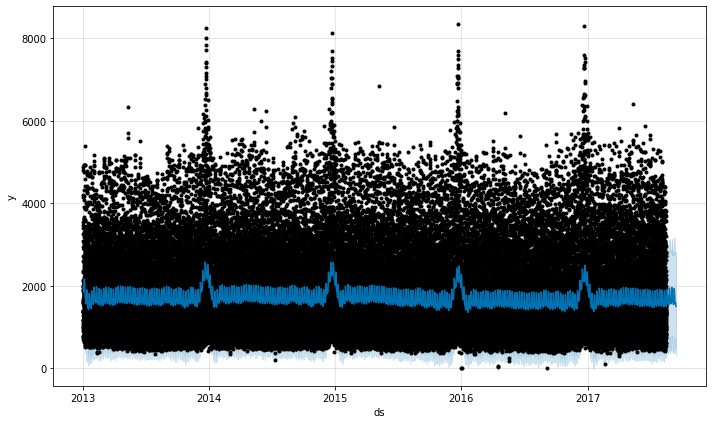

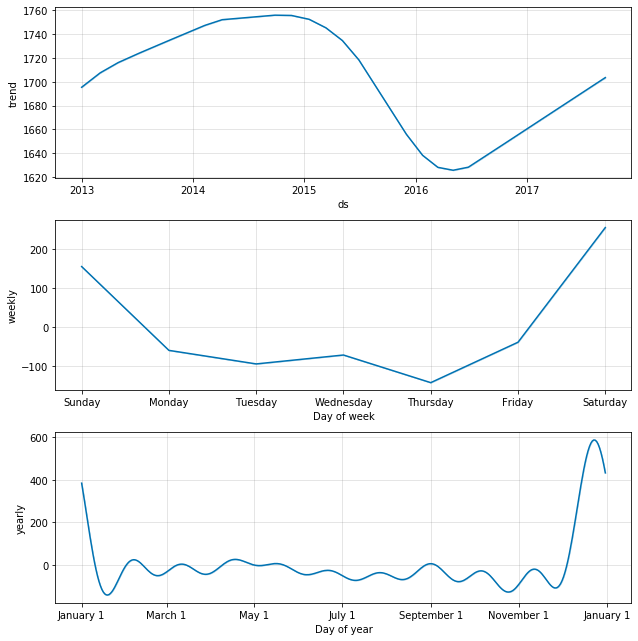

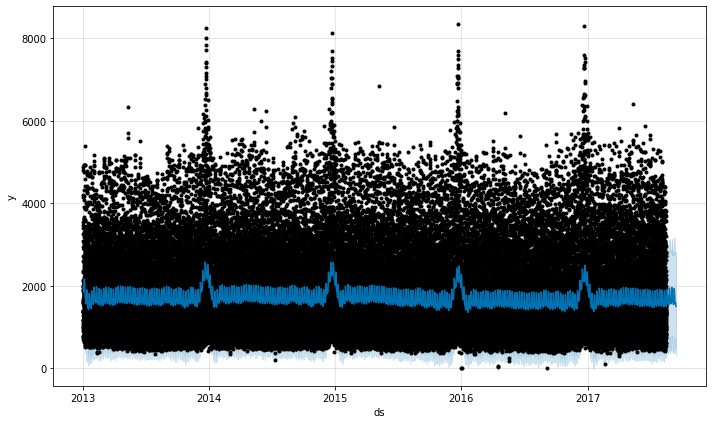

In [5]:
model = Prophet().fit(transx)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot_components(forecast)

The above graphs show the trends for our forecast according to each timeline;throughout the dataset timeframe, yearly and weekly. 
Lets aggregate our visualization by store number for more actionable information.

In [6]:
grouped = transx.groupby('store_nbr')
final = pd.DataFrame()
for g in grouped.groups:
    group = grouped.get_group(g)
    m = Prophet()
    m.fit(group)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)    
    forecast = forecast.rename(columns={'yhat': 'yhat_'+str(g)})
    final = pd.merge(final, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

final = final[['yhat_' + str(g) for g in grouped.groups.keys()]]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\MOLPP\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality

In [26]:

import plotly.express as px
from scipy.signal import savgol_filter
fig = px.line(final, x='ds', y='yhat_41')
fig.show()

In [22]:
final.head()

,ds,yhat_1,yhat_2,yhat_3,yhat_4,yhat_5,yhat_6,yhat_7,yhat_8,yhat_9,...,yhat_45,yhat_46,yhat_47,yhat_48,yhat_49,yhat_50,yhat_51,yhat_52,yhat_53,yhat_54
0,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1975.580891,2200.393036,3588.882447,1863.186600,1919.064395,2129.521621,1828.062544,3287.527218,2492.328635,...,4085.405298,4330.344106,4374.956524,3447.764628,2454.920645,2997.558431,2147.050864,NaN,NaN,931.794865
2,2013-01-03,1825.225453,2020.884410,3250.653608,1684.022043,1796.790199,1945.761387,1666.527941,3002.254613,2493.971974,...,3707.025164,4010.009427,4025.094191,3251.979635,2167.423222,2834.336376,1867.549252,NaN,NaN,902.397616
3,2013-01-04,1825.250021,2102.806649,3523.331610,1775.776533,1836.189192,2031.345159,1823.794747,3183.487463,2299.794098,...,4182.832497,4216.146596,4276.250043,3392.841839,2460.046832,3038.400525,2103.172982,NaN,NaN,931.109452
4,2013-01-05,1346.230631,2202.868316,3865.711188,1914.576900,1872.794328,2351.872684,1679.660572,3190.218102,2779.182711,...,4765.551584,5265.573775,5051.429694,4341.125832,2778.777736,3724.980993,2163.913891,NaN,NaN,1089.459040
